# IFN-646 Project: Images Classification of Breast Cancer

## Description

In this file, we will perform how we run the classifiers to classify which case considered as **BENIGN** or **MALIGNANT**.

### Data Cleaning and Wrangling

In this section of code, we will do the Data cleaning and Wrangling including do the stratified sampling.

In [1]:
#Import Library needed
import pandas as pd
import os
import re
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, AveragePooling2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
import IPython
tf.keras.backend.clear_session()
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-22dcb71e9ece>:31: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
#Function to set the subject ID for calc and mass dataset
def generate_full_mask(name, file):
    df_full = pd.read_csv(file)
    df_full[['assessment', 'abnormality id']] = df_full[['assessment', 'abnormality id']].astype(str)
    df_full['Subject ID'] = name+df_full['patient_id']+'_'+df_full['left or right breast']+'_'+df_full['image view']
    df_mask = pd.read_csv(file)
    df_mask[['assessment', 'abnormality id']] = df_mask[['assessment', 'abnormality id']].astype(str)
    df_mask['Subject ID'] = name+df_mask['patient_id']+'_'+df_mask['left or right breast']+'_'+df_mask['image view']+'_'+df_mask['abnormality id']
    df_full = df_full.drop_duplicates(subset=['Subject ID'], keep='first')
    df_mask = df_mask.drop_duplicates(subset=['Subject ID'], keep='first')
    return df_full, df_mask

#Function to get the pathfile
def get_name(directory):

    names = []

    for root, dirs, files in os.walk(directory):
        for filename in files:
            _, ext = os.path.splitext(filename)
            if ext in ['.png']:
                names.append(os.path.join(root, filename))

    return names

def merge_path(data1, data2, tpe):
    #Select necessary column to match with metadata from calc and mass dataset
    data1 = data1.iloc[:,[8,9,14]]
    data2 = data2.iloc[:,[8,9,14]]
    merge1 = pd.merge(data1, result, on='Subject ID', how='inner')
    merge2 = pd.merge(data2, result, on='Subject ID', how='inner')
    #Only select the mask file, which start with 1-2.dcm (Thus keep the last)
    merge2 = merge2.drop_duplicates(subset=['Subject ID'], keep='last')
    #Re-index the dataframe
    merge1 = merge1.reindex(columns=['Subject ID','assessment','pathology','Match','Pathfile'])
    merge2 = merge2.reindex(columns=['Subject ID','assessment','pathology','Match','Pathfile'])
    #Change the Benign Without Callback to Benign
    merge1['pathology'] = merge1['pathology'].replace(['BENIGN_WITHOUT_CALLBACK'],'BENIGN')
    merge2['pathology'] = merge2['pathology'].replace(['BENIGN_WITHOUT_CALLBACK'],'BENIGN')
    #Rename the pathfile into mask for mask dataset before merge
    merge2 = merge2.rename(columns={"Pathfile" : "Mask"})
    #Rename the subject ID for mask dataset before mergex
    merge2['Subject ID'] = merge2['Subject ID'].str[:-2]
    #merge two dataframe into one with pathfile for mask and raw image
    merge = pd.merge(merge1, merge2, on=['Subject ID','assessment','pathology'], how='inner')
    #keep neccessary column
    merge = merge.iloc[:,[0,1,2,4,6]]
    #make new column to help sampling
    merge['assessment'] = merge['assessment'].astype(int)
    conditions = [(merge['assessment'] == 4),(merge['assessment'] < 4),(merge['assessment'] > 4)]
    choices = [2, 1, 3]
    # Add new column based on conditions and choices:
    merge['sampling'] = np.select(conditions, choices, default='error')
    merge['sampling'] = merge['sampling'].astype(int)
    merge['type'] = tpe
    return merge

In [3]:
#Initiate dataset
calc_train_full, calc_train_mask = generate_full_mask('Calc-Training_','calc_case_description_train_set.csv')
calc_test_full, calc_test_mask = generate_full_mask('Calc-Test_', 'calc_case_description_test_set.csv')
mass_train_full, mass_train_mask = generate_full_mask('Mass-Training_','mass_case_description_train_set.csv')
mass_test_full, mass_test_mask = generate_full_mask('Mass-Test_','mass_case_description_test_set.csv')
metadata = pd.read_csv('metadata.csv')

In [4]:
#Initiate the variable to get the pathfile for each images
names = get_name('CBIS-DDSM')
#Make it into dataframe
names = pd.DataFrame(names,columns=['Pathfile'])
#Make the Match Column to match with File Location in metadata
names['Match'] = names['Pathfile'].str[:-12]
#Make a new column called Match for joining the metadata with pathfile from names
metadata['Match'] = metadata['File Location'].str[2:]
#Drop unnecessary column from metadata
metadata = metadata.iloc[:,[4,17]]
#Merge the new PNG pathfile to metadata
result = pd.merge(metadata, names, on='Match', how='inner')

In [5]:
#Pathfile for each dataset
calc_train = merge_path(calc_train_full,calc_train_mask, 'calc')
calc_test = merge_path(calc_test_full,calc_test_mask, 'calc')
mass_train = merge_path(mass_train_full,mass_train_mask, 'mass')
mass_test = merge_path(mass_test_full,mass_test_mask, 'mass')

In [6]:
# concat calc and mass dataset
training = pd.concat([calc_train, mass_train])
test = pd.concat([calc_test, mass_test])

## Data Split

In [7]:
def split(data, stratify, size):
    rs = 10
    # target/input split
    Y = data.loc[:,['pathology']]
    X = data.drop(['pathology'], axis=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, 
                                                        stratify=data[stratify], 
                                                        random_state=rs)
    return X_test, Y_test

In [8]:
#create the assess 4 dataframe
assess_4 = training.loc[training['sampling'] == 2]
#sampling the data (50% from sampling data will be based on this data, so the proportion is 0.3*0.5)
sample_4, target_4 = split(assess_4, ['pathology','type'], 0.2)
#create the assess 1-3 and 4-6
assess_1 = training.loc[training['sampling'] == 1]
#sampling
sample_1, target_1 = split(assess_1, ['pathology','type'], 0.2)
#create the assess 1-3 and 4-6
assess_5 = training.loc[training['sampling'] == 3]
#sampling
sample_5, target_5 = split(assess_5, ['pathology','type'], 0.2)
#merge sampling
training_sample = pd.concat([sample_1, sample_4, sample_5])
training_target = pd.concat([target_1, target_4, target_5])
training_target['encode'] = np.where(training_target['pathology'] != 'BENIGN', 0, 1)

In [9]:
len(training_sample)

566

<AxesSubplot:>

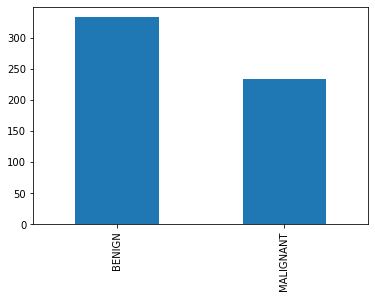

In [10]:
#Pathology plot from training sample
training_target.pathology.value_counts().plot(kind='bar')

In [11]:
#Sampling the test dataset
assess_4 = test.loc[test['sampling'] == 2]
#sampling the data
sample_4, target_4 = split(assess_4, ['pathology','type'], 0.15)
#create the assess 1-3
assess_1= test.loc[test['sampling'] == 1]
#sampling
sample_1, target_1 = split(assess_1, ['pathology','type'], 0.25)
#create the assess 5-6
assess_5 = test.loc[test['sampling'] == 3]
#sampling
sample_5, target_5 = split(assess_5, ['pathology','type'], 0.25)
#merge sampling
test_sample = pd.concat([sample_1, sample_4, sample_5])
test_target = pd.concat([target_1, target_4, target_5])
test_target['encode'] = np.where(test_target['pathology'] != 'BENIGN', 0, 1)

In [12]:
len(test_sample)

141

<AxesSubplot:>

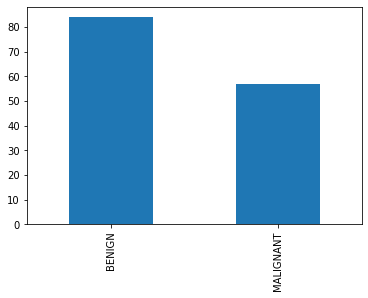

In [13]:
#Pathology plot from test sample
test_target.pathology.value_counts().plot(kind='bar')

## Classifier - Efficient Net B0

In [14]:
#Function to load image
def load_image(path, target_size, scale_factor):     
    im = Image.open(path)
    w, h = im.size
    im = im.resize((target_size, target_size))
    im=np.asarray(im) / scale_factor
    return np.asarray(im)

In [15]:
training_full_img = []
training_mask_img = []
test_full_img = []
test_mask_img = []

training_full = training_sample['Pathfile']
training_mask = training_sample['Mask']
test_full = test_sample['Pathfile']
test_mask = test_sample['Mask']

train_pathology = np.asarray(training_target['encode'])
test_pathology = np.asarray(test_target['encode'])

#iteration to read the image
for path in training_full:
    load = load_image(path,512,255.0)
    training_full_img.append(load)
for path in training_mask:
    load = load_image(path,512,255.0)
    training_mask_img.append(load)
for path in test_full:
    load = load_image(path,512,255.0)
    test_full_img.append(load)
for path in test_mask:
    load = load_image(path,512,255.0)
    test_mask_img.append(load)

In [16]:
training_full_img = np.reshape(training_full_img, (len(training_full_img),512,512,1))
training_mask_img = np.reshape(training_mask_img, (len(training_full_img),512,512,1))
test_full_img = np.reshape(test_full_img, (len(test_full_img),512,512,1))
test_mask_img = np.reshape(test_mask_img, (len(test_mask_img),512,512,1))

In [17]:
train_pathology = keras.utils.to_categorical(train_pathology, 2)
test_pathology = keras.utils.to_categorical(test_pathology, 2)

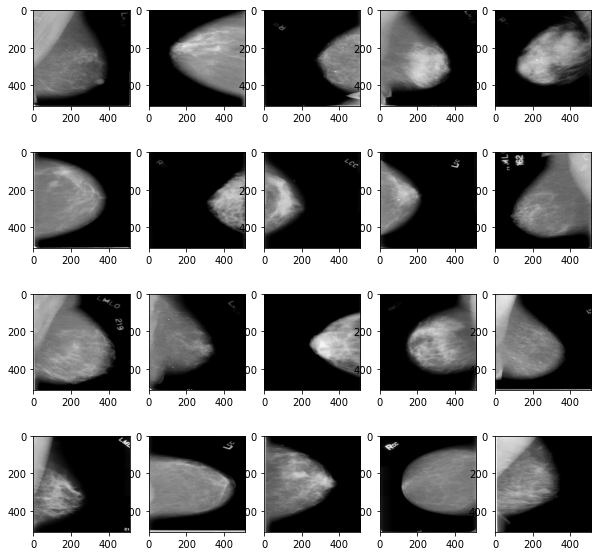

In [18]:
#Show image to check if it's load without error
fig = plt.figure(figsize=[10, 10])
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.imshow(training_full_img[i,:,:,:], cmap='gray')

In [19]:
img_input = tf.keras.layers.Input(shape=(512, 512,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    
efficient_net = EfficientNetB0(weights='imagenet', input_tensor=img_conc, include_top=False, pooling='max')
output = efficient_net.layers[-1].output
output = Dense(2, activation='sigmoid')(output)
model_cnn = keras.Model(inputs=efficient_net.input, outputs=output, name='DDSM_Classifier')
model_cnn.summary()

Model: "DDSM_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 512, 512, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['concatenate[0][0]

 block6c_project_bn (BatchNorma  (None, 16, 16, 192)  768        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 16, 16, 192)  0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 16, 16, 192)  0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, 16, 16, 1152  221184      ['block6c_add[0][0]']            
                                )                                                                 
          

In [20]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='binary_crossentropy', 
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [21]:
history = model_cnn.fit(training_full_img,train_pathology,
                    batch_size=32,
                    epochs=10,
                    validation_data=(test_full_img, test_pathology))

Epoch 1/10
18/18 [==============================] - 758s 41s/step - loss: 1.7457 - categorical_accuracy: 0.5954 - val_loss: 0.9200 - val_categorical_accuracy: 0.5957
Epoch 2/10
18/18 [==============================] - 817s 46s/step - loss: 0.9086 - categorical_accuracy: 0.6608 - val_loss: 0.8101 - val_categorical_accuracy: 0.5957
Epoch 3/10
18/18 [==============================] - 526s 29s/step - loss: 0.5620 - categorical_accuracy: 0.7739 - val_loss: 1.0223 - val_categorical_accuracy: 0.4255
Epoch 4/10
18/18 [==============================] - 535s 30s/step - loss: 0.3423 - categorical_accuracy: 0.8887 - val_loss: 0.9675 - val_categorical_accuracy: 0.4043
Epoch 5/10
18/18 [==============================] - 535s 30s/step - loss: 0.2146 - categorical_accuracy: 0.9311 - val_loss: 0.7688 - val_categorical_accuracy: 0.5957
Epoch 6/10
18/18 [==============================] - 543s 30s/step - loss: 0.2338 - categorical_accuracy: 0.9364 - val_loss: 0.8855 - val_categorical_accuracy: 0.5957
Epoc

In [22]:
# Save the model
model_cnn.save('DDSM2.h5')

C:\Users\samue\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


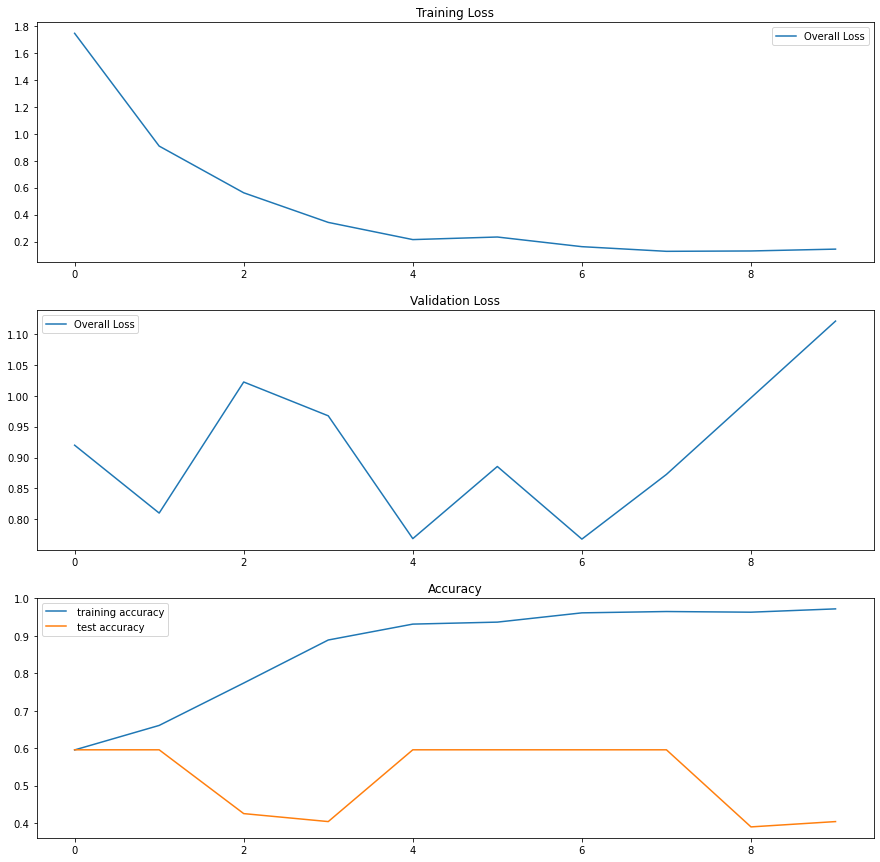

In [23]:
def eval_models(model, x_test, y_test, history):
    
    fig = plt.figure(figsize=[15, 15])
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(history.history['loss'], label = 'Overall Loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(history.history['val_loss'], label = 'Overall Loss')
    ax.legend()
    ax.set_title('Validation Loss')
    
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(history.history['categorical_accuracy'], label = ' training accuracy')
    ax.plot(history.history['val_'+'categorical_accuracy'], label = ' test accuracy')
    ax.legend()
    ax.set_title('Accuracy')

eval_models(model_cnn, test_full_img, test_pathology, history)

In [24]:
def Confusion_matrix (model, x_test, y_test):

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm)
    c.plot(ax = ax)

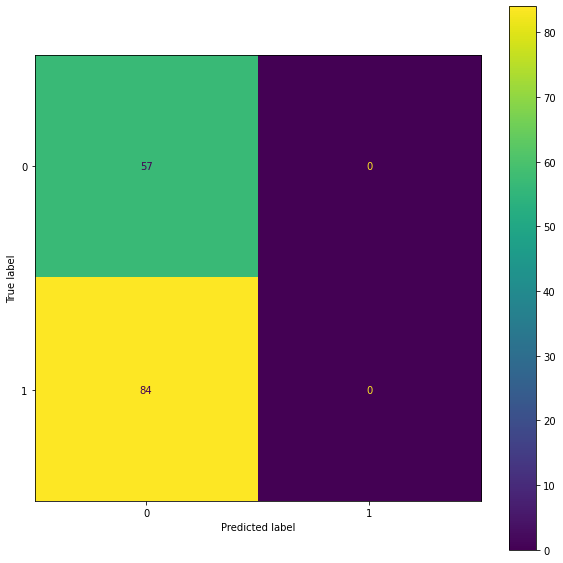

In [25]:
pred = model_cnn.predict(test_full_img)
indexes = tf.argmax(pred, axis=1)
i = tf.cast([], tf.int32)
indexes = tf.gather_nd(indexes, i)

cm = confusion_matrix(test_target['encode'], indexes)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax)

Apparently, our confusion matrix show really bad prediction with the current model. One of the reason would be the assessment 4 which the benign and malignant it's a bit tricky to be classified. Let's have a look with the number of pathology for assessment 4.

<AxesSubplot:>

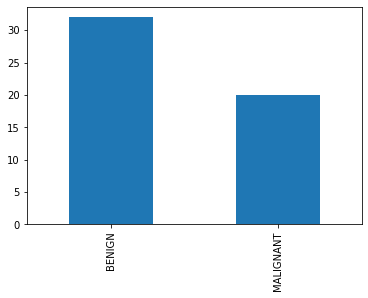

In [26]:
target_4.pathology.value_counts().plot(kind='bar')

As we can see from the plot above, the assessment 4 has a fairly balanced benign and malignant class (which indecisive) and made the classifier harder to learn about this class.

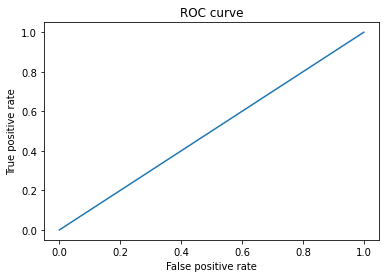

In [27]:
#ROC Curve
pred = model_cnn.predict(test_full_img)
indexes = tf.argmax(pred, axis=1)
i = tf.cast([], tf.int32)
indexes = tf.gather_nd(indexes, i)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_target['encode'], indexes)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()